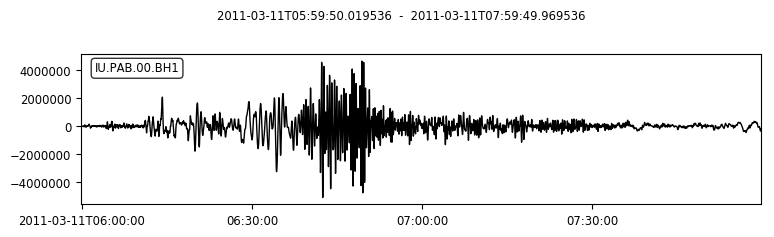

In [10]:
import obspy
import obspy.signal
from obspy import read
from obspy.imaging.spectrogram import spectrogram
from obspy.signal.cross_correlation import correlate,xcorr_max
from IPython.display import display, Markdown
import numpy as np
import copy
import warnings
warnings.filterwarnings('ignore')
st=read("2011-03-11-mw91-near-east-coast-of-honshu-japan-2.miniseed")
# setup the function for interactive picking by right-click on the graphic: 
def onclick(event):
    if event.button == 3: 
        pos.append([event.xdata,event.ydata])
        plt.text(event.xdata, event.ydata, 'o', color='r',weight='bold',\
        horizontalalignment='center',verticalalignment='center')
        print([event.xdata,event.ydata])
def PlotTarr():
    global freqs,tarr
    fig0.canvas.mpl_disconnect(cid)
    def TakeFirst(elem):
        return elem[1]
    posa=sorted(pos,key=TakeFirst)
    posa=np.asarray(posa)
    freqs=posa[:,1];# (store the frequencies in vector freq)
    tarr=posa[:,0]; # (store the arrival times in vector tarr)
    fig = plt.figure(figsize=(10,6));
    ax1 = fig.add_axes([0.1, 0.5, 0.7, 0.45]) #[left bottom width height]
    ax1.plot(freqs, tarr, 'o')
def ComputeApparentVelocity():
    global vels,freqs
    fig0.canvas.mpl_disconnect(cid)
    def TakeFirst(elem):
        return elem[1]
    posa=sorted(pos,key=TakeFirst)
    posa=np.asarray(posa)
    freqs=posa[:,1];# (store the frequencies in vector freq)
    tarr=posa[:,0]; # (store the arrival times in vector tarr)
    Tp=13*60+27;To=2*60;dist=96*111;
    tarra=tarr+Tp-To;
    vels=dist/tarra;
def PlotDispersionCurve():
    fig3,ax3=plt.subplots(figsize=(10,6));
    ax3.plot(1/freqs,vels,'.');ax3.set_xlim(0,1000)
def PlotApproxDepthVelocity():
    deps=np.multiply(vels,.25/freqs)
    fig4,ax4=plt.subplots(figsize=(10,6));
    ax4.plot(vels,deps,'.b');ax4.plot(vels,deps);
    ax4.set_ylim(0,1000);ax4.invert_yaxis()
    ax4.set_xlabel('period (s)')
def PlotAndClick(ti,tf):
    global fig0
    global cid
    global pos
    i=1;pos=[]
    %matplotlib notebook
    import matplotlib
    import matplotlib.pyplot as plt
    fig0 = plt.figure(figsize=(10,10));
    ax1 = fig0.add_axes([0.1, 0.5, 0.7, 0.45]) #[left bottom width height]
    ax2 = fig0.add_axes([0.1, 0.1, 0.7, 0.35], sharex=ax1)
    t = np.arange(st[i].stats.npts) / st[i].stats.sampling_rate
    tstart=st[i].stats.starttime
    ax1.plot(t, st[i].data, 'k')
    st[i].spectrogram(show=True, axes=ax2,log=True,wlen=200)
    ax2.set_ylim(0.0003,.1)
    ax1.set_xlim(ti*60,tf*60)
    cid=fig0.canvas.mpl_connect('button_press_event', onclick)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
st[0].plot()
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

# Use these "functions" in the correct chronological sequence:
###  PlotAndClick(XX,YY):
Plot a portion of the seismogram from minute XX to minute YY<br>
Plot the spectrogram (power spectrum as a function of arrival time)<br>
**RIGHT CLICK OF MOUSE to select ARRIVAL TIMES $t_{arr}$**
### PlotDispersionCurve():
Show the apparent velocity as a function of the wave period
### ComputeApparentVelocity():
Transform the arrival times into apparent velocities for each frequency
This uses the epicentral distance of $96^o$ and the equation:
$$
V=\Delta\times 111 / t_{arr}
$$
### PlotApproxDepthVelocity():
This shows an indicative approximation of depth - velocity curve.<br>
Uses picked values to : <br> 1) Estimate apparent velocities as Distance / Traveltime for each frequency <br> 2) Make a crude estimate of depth-velocity profile
$$
z\approx \frac{1}{4}\ \frac{c(f)}{f}
$$
where $c$ is velocity and $f$ is frequency

<IPython.core.display.Javascript object>


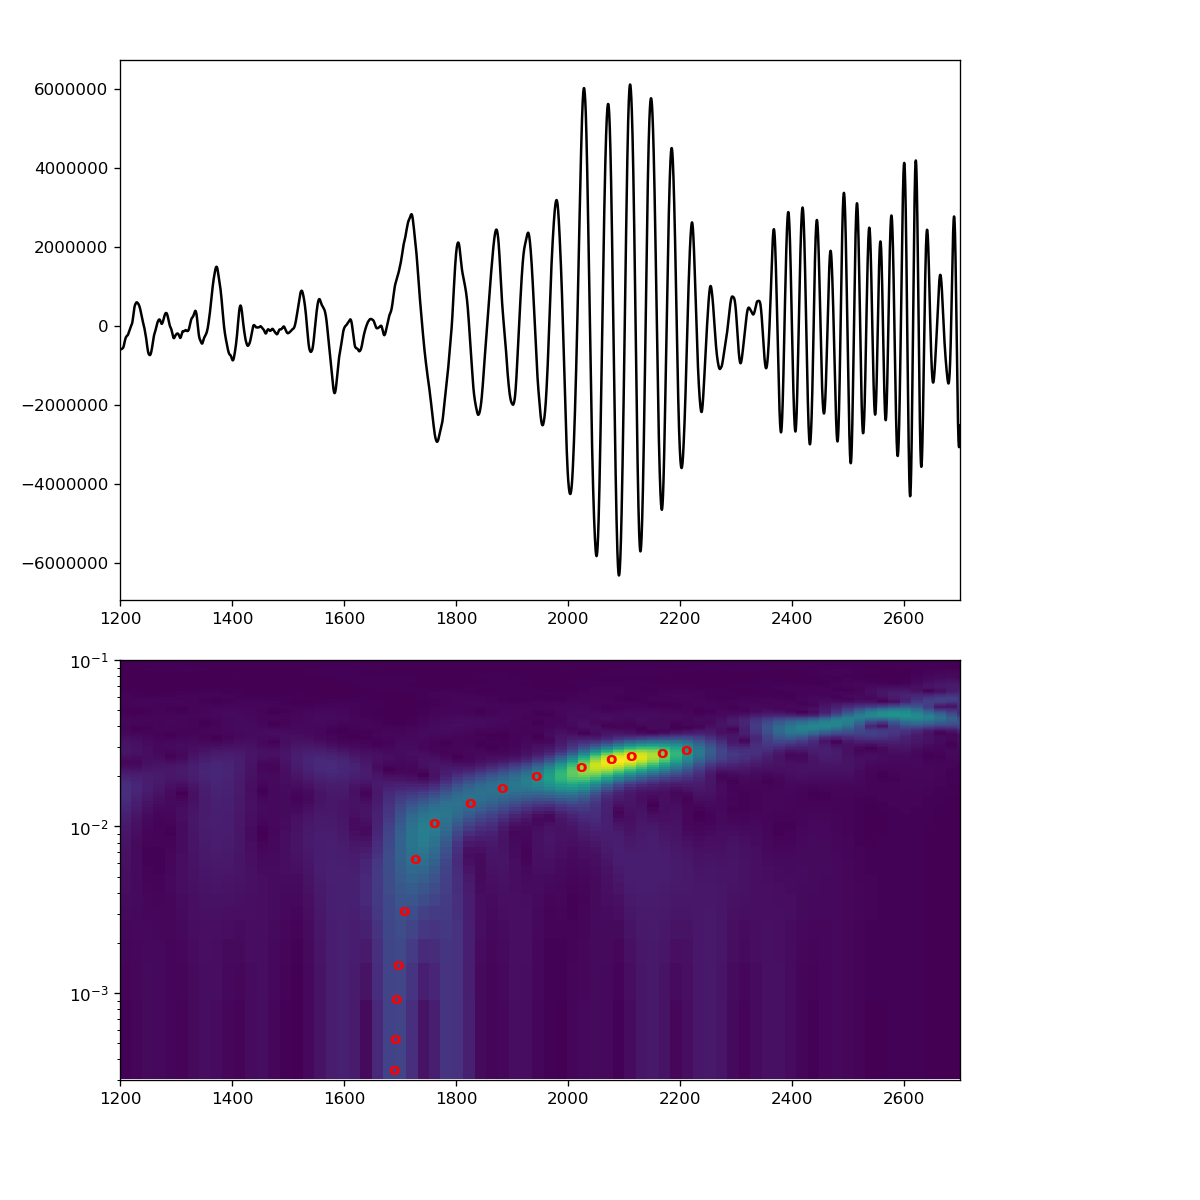

In [11]:
PlotAndClick(20,45)

In [12]:
ComputeApparentVelocity()

<IPython.core.display.Javascript object>


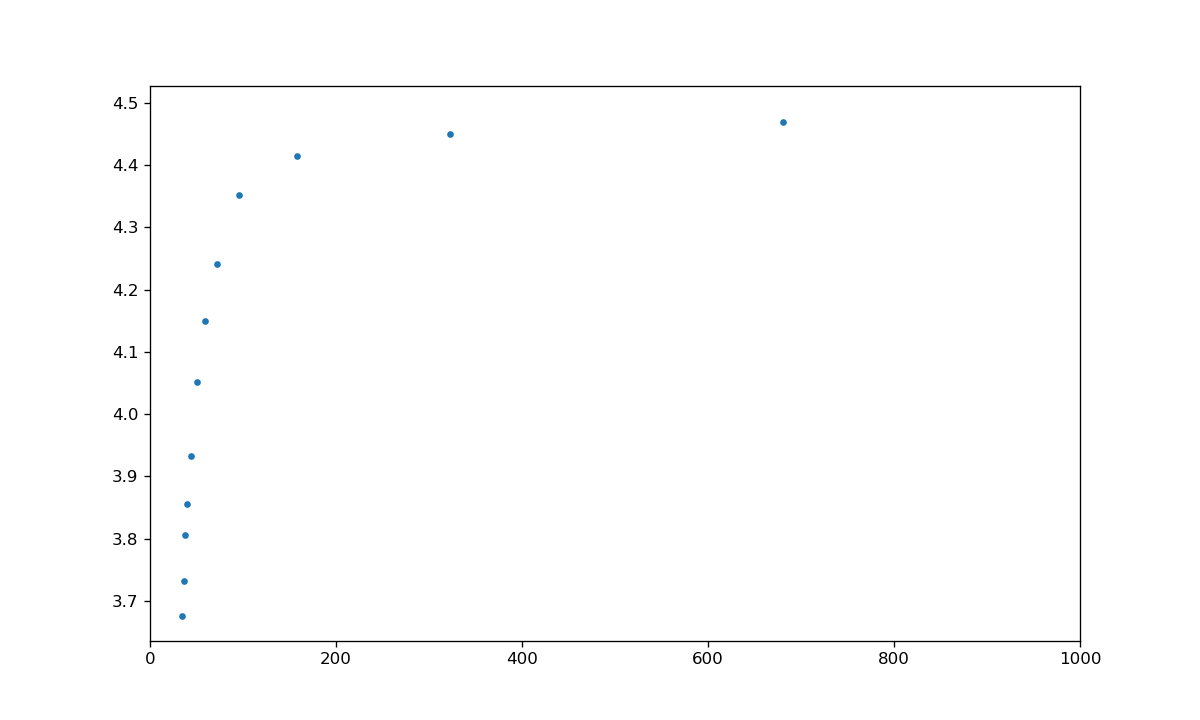

In [13]:
PlotDispersionCurve()

<IPython.core.display.Javascript object>


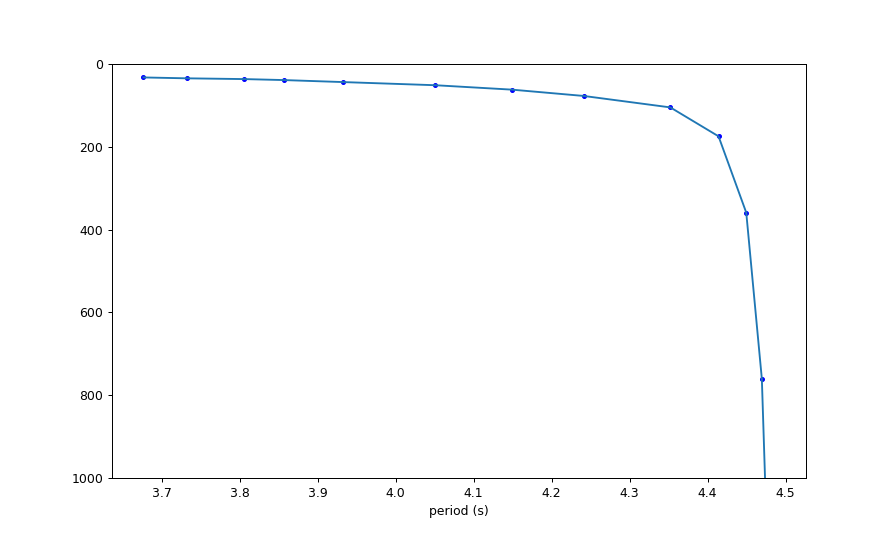

In [14]:
PlotApproxDepthVelocity()

# Compute the theoretical dispersion curve for a layer over a half space
The velocity $c$ for a given angular frequency $\omega=2\pi f$ is obtained by
solving the equation:
$$
\tan \omega\, H \sqrt{\beta_1^{-2}-c^{-2}} = 
\frac{\mu_2}{\mu_1}\frac{\sqrt{c^{-2}-\beta_2^{-2}}}{\sqrt{\beta_1^{-2}-c^{-2}}}
$$
where: <br>
$H$ is thickness of top layer,<br>
$\beta_1$ and $\beta_2$ are shear wave velocities in top layer and half-space, <br>
$\mu_1$ and $\mu_2$ are shear moduli in top layer and half-space. 

Here a value of $c$ is sought which minimizes the difference defined as :
$$
\textrm{diff}(c)=\tan \omega\, H \sqrt{\beta_1^{-2}-c^{-2}} - 
\frac{\mu_2}{\mu_1}\frac{\sqrt{c^{-2}-\beta_2^{-2}}}{\sqrt{\beta_1^{-2}-c^{-2}}}
$$
To this purpose the python optimization routine __fsolve__ is used.


### Finally, the theoretical prediction (red) is plotted against the dispersion curve (blue) obtained from the spectrogram.

## In the cell below, try different values of b1 ($\beta_1$) and $H$:



<IPython.core.display.Javascript object>


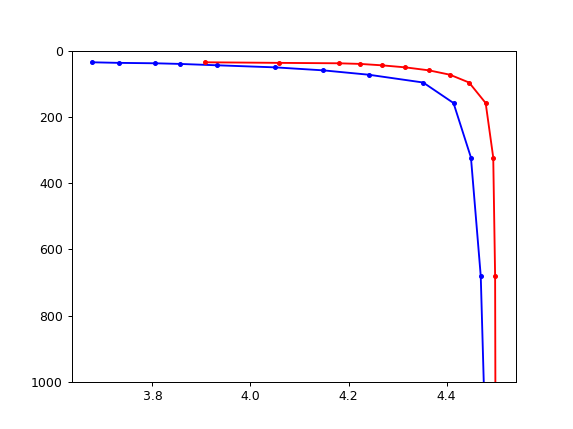

In [16]:

b1=3;H=13; # these are the values to be "altered"
########################################################
########################################################

#
#
b2=4.5  # assume this "low freq" limit well constrained - keep fixed 
mur=1.5  # assume ratio of elastic moduli is fixed

#
from scipy.optimize import fsolve
# define the difference function which needs to be minimised:
def diff(x):
    y = np.tan(w*H*np.sqrt((1/b1**2)-1/x**2) ) \
    - mur*np.sqrt(1/x**2-1/b2**2)/np.sqrt(1/b1**2-1/x**2)
    # Bounce off a very large value of misfit 
    # if velocity higher than fundamental mode.
    # This will avoid selection of other modes:
    if x > cmax: y=1e20 
    return y

# Find the minimum for each frequency value in a loop,
# store results in lists vv (velocities) and and ww (periods):
vv=[];ww=[];
for w in 2*3.1416*freqs:
    cmin=b1;cmax=b2;
    # cmax is maximum velocity for the FIRST mode in the solution
    # becasue tan has infinite solutions for each n*2*pi, we want only n=0. 
    if 1/b1**2 - (1/(2*w*H))**2 > 0:
        cmax=(   1/b1**2 - (1/(2*w*H))**2  )**(-1/2)
    if cmax < cmin: cmax=cmin
    c0 = fsolve(diff, 1.01*cmin)[0]
    vv.append(c0);ww.append(2*3.1416/w)
    
# Plot the theoretical and observed dispersion curves:
fig,ax=plt.subplots()
ax.plot(vels,1/freqs,'.b');ax.plot(vels,1/freqs,'b')
ax.plot(vv,ww,'.r');ax.plot(vv,ww,'r')
#ax.plot(vels,deps);
ax.set_ylim(0,1000)
ax.invert_yaxis()